# Title

# Description

In [47]:
pip install category_encoders

In [48]:
!pip install pmdarima

# Importation

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

import warnings
import os
warnings.filterwarnings("ignore")
from google.colab import drive

# Data Loading

In [50]:
train = pd.read_csv('https://raw.githubusercontent.com/ikoghoemmanuell/Forecast-the-Future-Naira-Exchange-Rate/main/Spot_Prices.csv', sep=',')

train.rename(columns={'Week of':'date', 'Cushing OK WTI Spot Price FOB $/bbl':'spot_price'}, inplace=True)
train['date'] = pd.to_datetime(train['date'])

# Filter the DataFrame to include data only from June 19, 1998, to May 12, 2023
start_date = '1998-06-19'
end_date = '2023-05-12'

# Filter based on the date range
mask = (train['date'] >= start_date) & (train['date'] <= end_date)
train = train.loc[mask]

train.set_index('date', inplace=True)

# Dataset overview

In [51]:
train.head()

,spot_price
date,
2023-05-12,72.03
2023-05-05,71.16
2023-04-28,76.31
2023-04-21,79.22
2023-04-14,81.87


In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 2023-05-12 to 1998-06-19
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   spot_price  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


In [53]:
train.describe()

,spot_price
count,1300.00
mean,59.89
std,27.48
min,3.32
25%,36.73
50%,57.97
75%,80.77
max,142.52


## Impute Missing Values

In [57]:
print(train.isnull().sum())

spot_price    0
dtype: int64


# Exploratory Data Analysis: EDA

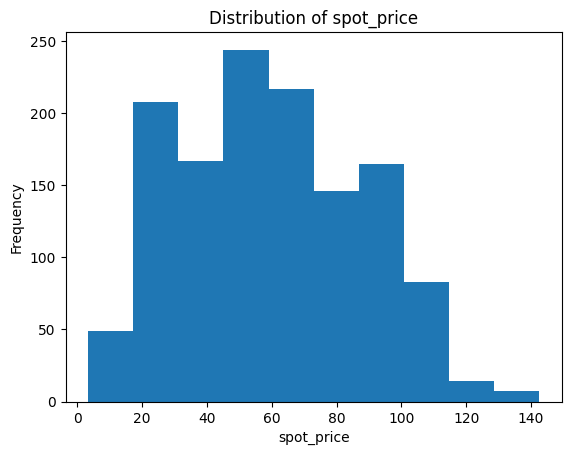

In [66]:
# Histogram of 'spot_price'
train['spot_price'].plot(kind='hist')
plt.xlabel('spot_price')
plt.ylabel('Frequency')
plt.title('Distribution of spot_price')
plt.show()

In [69]:
# Group by month and calculate sum of sales
monthly_sales = train.groupby(train.index.month)['spot_price'].sum()

# Find the month with the highest and lowest sales
highest_sales_month = monthly_sales.idxmax()
lowest_sales_month = monthly_sales.idxmin()

# Print the month with the highest sales
print("The month with the highest sales is:", highest_sales_month)
print("The month with the lowest sales is:", lowest_sales_month)

The month with the highest sales is: 7


# lag & time step features

# trend analysis

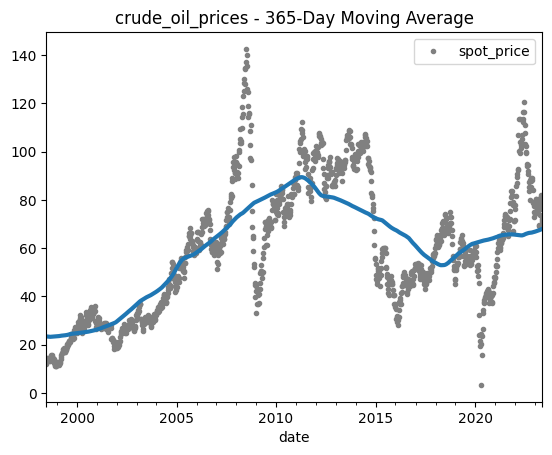

In [72]:
moving_average = train.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = train.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="crude_oil_prices - 365-Day Moving Average", legend=False,
);

In [73]:
dp = DeterministicProcess(
    index=train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X_dp = dp.in_sample()

X_dp.head()

,const,trend,trend_squared,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)",...,"s(51,52)","s(52,52)","sin(1,freq=Q-DEC)","cos(1,freq=Q-DEC)","sin(2,freq=Q-DEC)","cos(2,freq=Q-DEC)","sin(3,freq=Q-DEC)","cos(3,freq=Q-DEC)","sin(4,freq=Q-DEC)","cos(4,freq=Q-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2023-05-12,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.31,-0.95,-0.58,0.81,0.80,-0.60,-0.95,0.32
2023-05-05,1.00,2.00,4.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.71,-0.70,-1.00,-0.02,0.69,0.73,0.03,-1.00
2023-04-28,1.00,3.00,9.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.96,-0.29,-0.55,-0.83,-0.64,0.77,0.92,0.39
2023-04-21,1.00,4.00,16.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.98,0.19,0.37,-0.93,-0.84,-0.54,-0.69,0.73
2023-04-14,1.00,5.00,25.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.78,0.62,0.97,-0.22,0.43,-0.90,-0.43,-0.90


In [74]:
y_dp = train['spot_price']  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X_dp, y_dp)

y_dp_pred = pd.Series(model.predict(X_dp), index=X_dp.index)

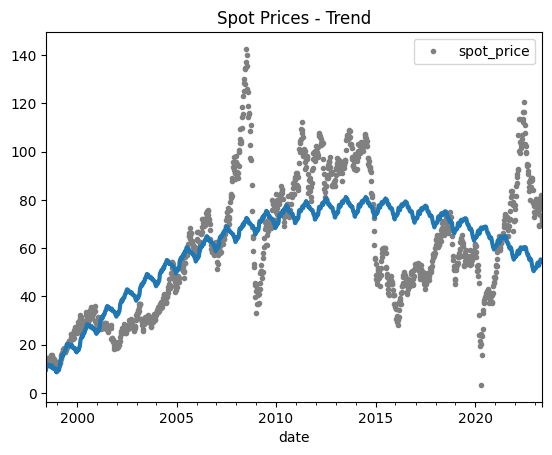

In [75]:
ax = train.plot(style=".", color="0.5", title="Spot Prices - Trend")
_ = y_dp_pred.plot(ax=ax, linewidth=3, label="spot prices")

In [76]:
X_dp_test = dp.out_of_sample(steps=100)
y_fore = pd.Series(model.predict(X_dp_test), index=X_dp_test.index)
y_fore

TypeError: CalendarFourier terms can only be computed from DatetimeIndex and PeriodIndex

# Feature Engineering

In [ ]:
# Define the getDateFeatures() function
def getDateFeatures(df):
    df.reset_index(inplace = True)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek.astype('object')

    # Use isocalendar to get the week number of the year
    df['weekofyear'] = df['date'].dt.isocalendar().week

    df['quarter'] = df['date'].dt.quarter
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)

    # Extract the 'year' and 'weekofyear' components from the 'date' column
    df['year_weekofyear'] = df['date'].dt.year * 100 + df['weekofyear']

    # create new columns to represent the cyclic nature of a year
    df['dayofyear'] = df['date'].dt.dayofyear
    df["sin(dayofyear)"] = np.sin(2 * np.pi * df["dayofyear"] / 365.25)
    df["cos(dayofyear)"] = np.cos(2 * np.pi * df["dayofyear"] / 365.25)

    df["is_weekend"] = np.where(df['dayofweek'] > 4, 1, 0)

    # Define the criteria for each season
    seasons = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Autumn': [9, 10, 11]}

    # Create the 'season' column based on the 'date' column
    df['season'] = df['month'].map({month: season for season, months in seasons.items() for month in months})
    df.set_index('date', inplace=True)

    return df

seasonal plots:

weekofyear vs dayofweek (line plot of prices for each week vs day of week)

encode dayofweek with onhotencoder, drop one day for linear regression, might help improve it

year vs dayofyear (line plot of prices for each year vs day of year)



In [ ]:
train = getDateFeatures(train)
train.head()

In [ ]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [ ]:
X = train.copy()
# X['dayofweek'] = X['dayofweek'].astype('int32')
# X['weekofyear'] = X['weekofyear'].astype('int32')

fig, (ax1) = plt.subplots(1, 1, figsize=(11, 3))
# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
# seasonal_plot(X, y="spot_price", period="weekofyear", freq="dayofweek", ax=ax0) # not needed since data is weekly so we have only one day of week so this will give us an empty chart if we plot it
seasonal_plot(X, y="spot_price", period="year", freq="dayofyear", ax=ax1);

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
plot_periodogram(train.spot_price);

this periodogram shows a weak annual season and no weekly season at all in our dataset.

 From right to left, the periodogram falls off between quarterly (4) and bimonthly (6), so let's use  4 pairs of Fourier terms for quarterly seasonality.

In [ ]:
fourier = CalendarFourier(freq="Q", order=4)  # 5 sin/cos pairs for seasonality

dp = DeterministicProcess(
    index=train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates

In [ ]:
y = train['spot_price']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [ ]:
m

## Features Encoding & scaling

In [ ]:
# train['store_id'] = train['store_id'].map(lambda x:x.split('_')[1]).astype(int)
# test['store_id'] = test['store_id'].map(lambda x:x.split('_')[1]).astype(int)

# train['category_id'] = train['category_id'].map(lambda x:x.split('_')[1]).astype(int)
# test['category_id'] = test['category_id'].map(lambda x:x.split('_')[1]).astype(int)

In [ ]:
train.season

In [ ]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns = train.select_dtypes(include=['object', 'category']).columns.tolist()
categoric_columns

In [ ]:
numeric_columns.remove('spot_price')

In [ ]:
encoder = BinaryEncoder(drop_invariant=False, return_df=True,)
encoder.fit(train[categoric_columns])

In [ ]:
# import pickle

# with open('encoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [ ]:
scaled_num = train[numeric_columns]

In [ ]:
encoded_cat = encoder.transform(train[categoric_columns])

In [ ]:
train = pd.concat([scaled_num, encoded_cat, train['spot_price']], axis=1)

**dataframe for the traditional time series models**

In [ ]:
train1 = train[['spot_price']].copy()

In [ ]:
train1.head()

In [ ]:
train.index = pd.to_datetime(train.index)

# Define the date ranges for validation and testing sets
validation_start_date = '2019-03-15'
validation_end_date = '2021-06-11'
testing_start_date = '2021-06-18'
testing_end_date = '2023-05-12'

# Create the validation set
eval = train.loc[validation_start_date:validation_end_date]

# Create the testing set
test = train.loc[testing_start_date:testing_end_date]

# The remaining data is used for training
train = train.drop(eval.index).drop(test.index)

# Optionally, you can check the lengths to ensure they match the specified weeks
print(f"Training set length: {len(train)}")
print(f"Validation set length: {len(eval)}")
print(f"Testing set length: {len(test)}")

In [ ]:
# Split data into parts
X_train = train.drop(['spot_price'], axis = 1)
y_train = train['spot_price']
X_test = test.drop(['spot_price'], axis = 1)
y_test = test['spot_price']

# Machine Learning Modeling

# Traditional Machine Learning Models

## AR

In [ ]:
x_train, x_test = y_train, y_test
print(f'train len: {len(x_train)}, test len: {len(x_test)}')

In [ ]:
pacf = plot_pacf(x_train,lags = 5)

In [ ]:
armodel = AutoReg(x_train, lags = 3).fit()

In [ ]:
pred = armodel.predict(
    start=len(x_train),
    end=len(x_train)+len(x_test) -1,
    dynamic = False
)
pred

In [ ]:
plt.plot(pred)
plt.plot(x_test, color='red')

In [ ]:
mse = mean_squared_error(x_test, pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(x_test, pred)).round(2)
msle = mean_squared_log_error(x_test, pred).round(2)
mae = mean_absolute_error(x_test, pred).round(2)
mape = mean_absolute_percentage_error(x_test, pred).round(2)
r2 = r2_score(x_test, pred).round(2)

results = pd.DataFrame([['AR', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])

## ARIMA

In [ ]:
# stepwise_fit = auto_arima(x_train, trace = True, suppress_warnings = True)
# stepwise_fit.summary()

In [ ]:
model = ARIMA(x_train, order=(3,1,3))
model_fit_arima = model.fit()
model_fit_arima.summary()

In [ ]:
# Make predictions on the test data
ARIMA_pred = model_fit_arima.predict(
    start=len(x_train),
    end=len(x_train)+len(x_test) -1,
    typ="levels")
ARIMA_pred

In [ ]:
plt.plot(ARIMA_pred)
plt.plot(x_test, color='red')

In [ ]:
# Evaluate our models
mse = mean_squared_error(x_test, ARIMA_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(x_test, ARIMA_pred)).round(2)
msle = mean_squared_log_error(x_test, ARIMA_pred).round(2)
mae = mean_absolute_error(x_test, ARIMA_pred).round(2)
mape = mean_absolute_percentage_error(x_test, ARIMA_pred).round(2)
r2 = r2_score(x_test, ARIMA_pred).round(2)

model_results = pd.DataFrame([['ARIMA', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
results = pd.concat([results, model_results], ignore_index=True)

## SARIMA

In [ ]:
model = SARIMAX(x_train, order=(5, 1, 5), seasonal_order=(0,0,0,0))
model_fit = model.fit()
model_fit.summary()

In [ ]:
# Make predictions on the test data
SARIMA_pred = model_fit.predict(
    start=len(x_train),
    end=len(x_train)+len(x_test) -1,
    typ="levels")
SARIMA_pred

In [ ]:
plt.plot(SARIMA_pred)
plt.plot(x_test, color='red')

In [ ]:
# Evaluate our models
mse = mean_squared_error(x_test, SARIMA_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(x_test, SARIMA_pred)).round(2)
msle = mean_squared_log_error(x_test, SARIMA_pred).round(2)
mae = mean_absolute_error(x_test, SARIMA_pred).round(2)
mape = mean_absolute_percentage_error(x_test, SARIMA_pred).round(2)
r2 = r2_score(x_test, SARIMA_pred).round(2)

model_results = pd.DataFrame([['SARIMA', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
results = pd.concat([results, model_results], ignore_index=True)

In [ ]:
# Evaluate our models
mse = mean_squared_error(x_test, abs(y_fore))
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(x_test, abs(y_fore))).round(2)
msle = mean_squared_log_error(x_test, abs(y_fore)).round(2)
mae = mean_absolute_error(x_test, abs(y_fore)).round(2)
mape = mean_absolute_percentage_error(x_test, abs(y_fore)).round(2)
r2 = r2_score(x_test, abs(y_fore)).round(2)

model_results = pd.DataFrame([['dp_trend & Linear Regr', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
results = pd.concat([results, model_results], ignore_index=True)

## Models Comparison

In [ ]:
results

## Model Evaluation (Backtests)

# Non-Traditional Time Series Models

### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
model_tree = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_tree.predict(X_test)

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(tree_pred, label='DecisionTreeRegressor')
plt.legend(loc='best')
plt.title('DecisionTreeRegressor Prediction')
plt.show()

In [ ]:
# Assume y_test and tree_pred are defined and have the same length
mse = mean_squared_error(y_test, tree_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)
msle = mean_squared_log_error(y_test, tree_pred).round(2)
mae = mean_absolute_error(y_test, tree_pred).round(2)
mape = mean_absolute_percentage_error(y_test, tree_pred).round(2)
r2 = r2_score(y_test, tree_pred).round(2)

results = pd.DataFrame([['DecisionTree', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(neigh_pred, label='KNeighborsRegressor')
plt.legend(loc='best')
plt.title('KNeighborsRegressor Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, neigh_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(2)
msle = mean_squared_log_error(y_test, neigh_pred).round(2)
mae = mean_absolute_error(y_test, neigh_pred).round(2)
mape = mean_absolute_percentage_error(y_test, neigh_pred).round(2)
r2 = r2_score(y_test, neigh_pred).round(2)

model_results = pd.DataFrame([['KNN', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
results = pd.concat([results, model_results], ignore_index=True)

### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Initialize and fit the Random Forest Regressor
forest = RandomForestRegressor()
model_forest = forest.fit(X_train, y_train)

# Make predictions on X_test
forest_pred = model_forest.predict(X_test)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(forest_pred, label='RandomForestRegressor')
plt.legend(loc='best')
plt.title('RandomForestRegressor Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, forest_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, forest_pred)).round(2)
msle = mean_squared_log_error(y_test, forest_pred).round(2)
mae = mean_absolute_error(y_test, forest_pred).round(2)
mape = mean_absolute_percentage_error(y_test, forest_pred).round(2)
r2 = r2_score(y_test, forest_pred).round(2)

model_results = pd.DataFrame([['Random Forest', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
# Append the results to the DataFrame
results = pd.concat([results, model_results], ignore_index=True)

### Support Vector Regression (SVR)

In [ ]:
from sklearn.svm import SVR

# Initialize and fit the SVR model
svr = SVR()
model_svr = svr.fit(X_train, y_train)

# Make predictions on X_test
svr_pred = model_svr.predict(X_test)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(svr_pred, label='Support Vector Regression')
plt.legend(loc='best')
plt.title('Support Vector Regression Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, svr_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, svr_pred)).round(2)
msle = mean_squared_log_error(y_test, svr_pred).round(2)
mae = mean_absolute_error(y_test, svr_pred).round(2)
mape = mean_absolute_percentage_error(y_test, svr_pred).round(2)
r2 = r2_score(y_test, svr_pred).round(2)

model_results = pd.DataFrame([['SVR', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
results = pd.concat([results, model_results], ignore_index=True)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and fit the Gradient Boosting model
gbr = GradientBoostingRegressor()
model_gbr = gbr.fit(X_train, y_train)

# Make predictions on X_test
gbr_pred = model_gbr.predict(X_test)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(gbr_pred, label='Gradient Boosting')
plt.legend(loc='best')
plt.title('Gradient Boosting Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, gbr_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, gbr_pred)).round(2)
msle = mean_squared_log_error(y_test, gbr_pred).round(2)
mae = mean_absolute_error(y_test, gbr_pred).round(2)
mape = mean_absolute_percentage_error(y_test, gbr_pred).round(2)
r2 = r2_score(y_test, gbr_pred).round(2)

model_results = pd.DataFrame([['Gradient Boosting', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
results = pd.concat([results, model_results], ignore_index=True)

### XGBoost

In [ ]:
import xgboost as xgb

# Initialize and fit the XGBoost model
xgboost = xgb.XGBRegressor()
model_xgboost = xgboost.fit(X_train, y_train)

# Make predictions on X_test
xgboost_pred = model_xgboost.predict(X_test)

mse = mean_squared_error(y_test, xgboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, xgboost_pred)).round(2)
msle = mean_squared_log_error(y_test, xgboost_pred).round(2)
mae = mean_absolute_error(y_test, xgboost_pred).round(2)
mape = mean_absolute_percentage_error(y_test, xgboost_pred).round(2)
r2 = r2_score(y_test, xgboost_pred).round(2)

model_results = pd.DataFrame([['XGBoost', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
results = pd.concat([results, model_results], ignore_index=True)

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize and fit the Linear Regression model
linear_reg = LinearRegression()
model_linear_reg = linear_reg.fit(X_train, y_train)

# Make predictions on X_test
linear_reg_pred = model_linear_reg.predict(X_test)

mse = mean_squared_error(y_test, linear_reg_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, linear_reg_pred)).round(2)
msle = mean_squared_log_error(y_test, linear_reg_pred).round(2)
mae = mean_absolute_error(y_test, linear_reg_pred).round(2)
mape = mean_absolute_percentage_error(y_test, linear_reg_pred).round(2)
r2 = r2_score(y_test, linear_reg_pred).round(2)

model_results = pd.DataFrame([['Linear Regression', msle, rmse, rmsle, mae, mse, mape, r2]],
                       columns=['Model', 'MSLE', 'RMSE', 'RMSLE', 'MAE', 'MSE', 'MAPE', 'R2'])
results = pd.concat([results, model_results], ignore_index=True)

## Models Comparison

In [ ]:
results

# Advanced Time Series Models

## Model Evaluation (Backtests)

# Hyperparameter Tuning

### predicting sales in our test

In [ ]:
test_pred = neigh.predict(test)
test_pred

In [ ]:
test.head()

In [ ]:
# test['spot_price'] = test_pred
# sub = test[['ID', 'spot_price']]

In [ ]:
# Save sample submission
# sub.to_csv('submission.csv', index=False)